# Imports

In [2]:
## load packages 
import pandas as pd
import re
import numpy as np

## nltk imports
import nltk
from nltk import pos_tag
from nltk.tokenize import word_tokenize

## uncomment and download if this is your first 
## time running 
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')

## sentiment analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

## specify to print all output in a call
## and not just first
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:
## spacy --- if you get an error at the load step
## need to download en_core_web_sm (google or try the next line)
#!python -m spacy download en_core_web_sm
import spacy
sp = spacy.load('en_core_web_sm')
import en_core_web_sm
nlp = en_core_web_sm.load()

# Load data 

In [6]:
## if working from within the repo and haven't yet unzipped the airbnb data, 
## can uncomment next line to unzip and find data in current dir
!unzip ../../public_data/airbnb_text.zip
path_todata = "airbnb_text.csv"

## load data
ab = pd.read_csv(path_todata, low_memory=False)
ab.head()
ab.info()

Archive:  ../../public_data/airbnb_text.zip
  inflating: airbnb_text.csv         


,id,name,name_upper,neighbourhood_group,price
0,2539,Clean & quiet apt home by the park,CLEAN & QUIET APT HOME BY THE PARK,Brooklyn,149
1,2595,Skylit Midtown Castle,SKYLIT MIDTOWN CASTLE,Manhattan,225
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,THE VILLAGE OF HARLEM....NEW YORK !,Manhattan,150
3,3831,Cozy Entire Floor of Brownstone,COZY ENTIRE FLOOR OF BROWNSTONE,Brooklyn,89
4,5022,Entire Apt: Spacious Studio/Loft by central park,ENTIRE APT: SPACIOUS STUDIO/LOFT BY CENTRAL PARK,Manhattan,80


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id                   48895 non-null  int64 
 1   name                 48879 non-null  object
 2   name_upper           48879 non-null  object
 3   neighbourhood_group  48895 non-null  object
 4   price                48895 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 1.9+ MB


# Text mining

## Manual approach 1: look for a single word

In [7]:
## using the `name_upper` var, look at where reviews mention cozy
ab['is_cozy'] = np.where(ab.name_upper.str.contains("COZY"), True, False)

## find the mean price by neighborhood and whether cozy
mp = pd.DataFrame(ab.groupby(['is_cozy', 'neighbourhood_group'])['price'].mean())

## reshape to wide format so that each borough is row
## and one col is the mean price for listings that describe
## the place as cozy; other col is mean price for listings
## without that word
mp_wide = pd.pivot_table(mp, index = ['neighbourhood_group'],
                        columns = ['is_cozy'])

mp_wide.columns = ['no_mention_cozy', 'mention_cozy']

mp_wide

,no_mention_cozy,mention_cozy
neighbourhood_group,,
Bronx,89.231088,74.214286
Brooklyn,128.175441,91.130224
Manhattan,204.109775,129.917140
Queens,102.596682,80.344388
Staten Island,120.650307,74.319149


### Practice: Look for word 'entire'

Repeat the previous code block, but this time create a new indicator for whether a listing name contains the word 'entire' and compare the prices across neighborhoods for listings with and without this word.

In [8]:
# solution
## using the `name_upper` var, look at where reviews mention cozy
ab['is_entire'] = np.where(ab.name_upper.str.contains("ENTIRE"), True, False)

## find the mean price by neighborhood and whether cozy
mp = pd.DataFrame(ab.groupby(['is_entire', 'neighbourhood_group'])['price'].mean())

## reshape to wide format so that each borough is row
## and one col is the mean price for listings that describe
## the place as cozy; other col is mean price for listings
## without that word
mp_wide = pd.pivot_table(mp, index = ['neighbourhood_group'],
                        columns = ['is_entire'])

mp_wide.columns = ['no_mention_entire', 'mention_entire']

mp_wide

,no_mention_entire,mention_entire
neighbourhood_group,,
Bronx,87.055037,112.421053
Brooklyn,123.879816,160.547101
Manhattan,196.969066,188.109649
Queens,99.110792,125.306818
Staten Island,114.439891,134.285714


## Manual approach 2: score based on dictionary of words

In [9]:
## construct dictionary
space_indicators = {'small': ['COZY', 'COMFY', 'LITTLE', 'SMALL'],
                   'large': ['SPACIOUS', 'LARGE', 'HUGE', 'GIANT']}


## for each listing, find the number of occurrences
## of words in each key

### first, let's test with one listing
practice_listing = "NICE AND COZY LITTLE APT AVAILABLE"

### splitting that string at space and looking at overlap with each key
### first, look at overlap with the list containing words for small
words_overlap_small = [word 
                    for word in practice_listing.split(" ") if 
                      word in space_indicators['small']]
words_overlap_small



['COZY', 'LITTLE']

In [10]:
### then, look at overlap with the list containing words for large
words_overlap_large = [word for word in practice_listing.split(" ") if 
                      word in space_indicators['large']]
words_overlap_large

### could then take length as a fraction of all words
len(words_overlap_small)/len(practice_listing.split(" "))
len(words_overlap_large)/len(practice_listing.split(" "))


[]

0.3333333333333333

0.0

### Practice: Score another listing

Using the same `space indicators` we just defined, score the following listing based on the proportion of words that belong to the "small" terms vs. the "large terms". Based on the scoring, would you say this place is "large", "small", or somewhere in-between?

In [11]:
practice_listing_new = "SPACIOUS PRIVATE BED & LARGE LIVING ROOM W/ OWN ENTRANCE IN COZY CELLAR"

In [12]:
# solution
## split words and check overlap
words_overlap_small_new = [word 
                           for word in practice_listing_new.split(" ") if 
                           word in space_indicators['small']]

### look at overlap with the list containing words for large
words_overlap_large_new = [word for word in practice_listing_new.split(" ") if 
                           word in space_indicators['large']]

### then take length as a fraction of all words
len(words_overlap_small_new)/len(practice_listing_new.split(" "))
len(words_overlap_large_new)/len(practice_listing_new.split(" "))


0.07692307692307693

0.15384615384615385

Seems like the listing leans toward being of "large" size!

## Part of speech tagging

In [13]:
## specify example
example_for_tag = "This is a chill apt next to the subway in LES Chinatown"
example_for_tag

'This is a chill apt next to the subway in LES Chinatown'

In [14]:
## try part of speech tagging using nltk
tokens = word_tokenize(example_for_tag) # Generate list of tokens
tokens_pos = pos_tag(tokens) # generate part of speech tags for those tokens
 
## returns a list of tuples
## first element in tuple is a word
## second element in tuple is the part of speech
#for one_tok in tokens_pos:
 #   print(one_tok)
tokens_pos

[('This', 'DT'),
 ('is', 'VBZ'),
 ('a', 'DT'),
 ('chill', 'NN'),
 ('apt', 'JJ'),
 ('next', 'JJ'),
 ('to', 'TO'),
 ('the', 'DT'),
 ('subway', 'NN'),
 ('in', 'IN'),
 ('LES', 'NNP'),
 ('Chinatown', 'NNP')]

In [15]:
## use list iteration to extract proper nouns (NNP)
## i'm first checking if the second element in the tuple
## is equal to NNP
## if so, i'm returning the first element in the tuple (the 
## actual word)
all_prop_noun = [one_tok[0] for one_tok in tokens_pos 
                if one_tok[1] == "NNP"]
all_prop_noun

all_adj_noun = [one_tok[0] for one_tok in tokens_pos 
                if one_tok[1] == "JJ" or 
               one_tok[1] == "NN"]
all_adj_noun

['LES', 'Chinatown']

['chill', 'apt', 'next', 'subway']

## Named Entity Recognition

In [16]:
## modified from a real tweet

## tweet
d_tweet = """We’ll be hosting on-campus COVID-19 booster clinics 
at Dartmouth College from 9 a.m. to 6 p.m. on
Monday, Jan. 10, and Tuesday, Jan. 11, at
Alumni Hall in the Hopkins Center. For information on how to
register and additional winter updates, head to
"""

In [17]:
spacy_dtweet = nlp(d_tweet)
print(type(spacy_dtweet))

<class 'spacy.tokens.doc.Doc'>


In [18]:
## try a couple variations
for one_tok in spacy_dtweet.ents:
    print("Entity: " + one_tok.text + "; NER tag: " + one_tok.label_)

Entity: COVID-19; NER tag: ORG
Entity: Dartmouth College; NER tag: ORG
Entity: 9 a.m. to 6 p.m.; NER tag: TIME
Entity: Monday, Jan. 10; NER tag: DATE
Entity: Tuesday, Jan. 11; NER tag: DATE
Entity: Alumni Hall; NER tag: FAC
Entity: the Hopkins Center; NER tag: FAC


### Challenge 1

Play around with different variations of the Dartmouth tweet and look at the results. For instance, try the following:

- What happens if you abbreviate New Hampshire to NH?
- What happens if you add the word Pfizer before COVID-19?
- What entities seem misclassified?

In [19]:
## tweet
d_tweet = """We’ll be hosting on-campus COVID-19 booster by Pfizer clinics 
at Dartmouth College in NH from 9 a.m. to 6 p.m. on
Monday, Jan. 10, and Tuesday, Jan. 11, at
Alumni Hall in the Hopkins Center. For information on how to
register and additional winter updates, head to
"""

spacy_dtweet = nlp(d_tweet)
print(type(spacy_dtweet))

## try a couple variations
for one_tok in spacy_dtweet.ents:
    print("Entity: " + one_tok.text + "; NER tag: " + one_tok.label_)

<class 'spacy.tokens.doc.Doc'>
Entity: COVID-19; NER tag: ORG
Entity: Pfizer; NER tag: ORG
Entity: Dartmouth College; NER tag: ORG
Entity: NH; NER tag: ORG
Entity: 9 a.m. to 6 p.m.; NER tag: TIME
Entity: Monday, Jan. 10; NER tag: DATE
Entity: Tuesday, Jan. 11; NER tag: DATE
Entity: Alumni Hall; NER tag: FAC
Entity: the Hopkins Center; NER tag: FAC


### Challenge 2

How do we generalize from doing Named Entity Recognition one just one string to doing NER on a whole column that contains strings? By defining and executing a **function**, of course!

Using the following sample of strings from airbnb listing names, define a function that takes in one airbnb string and does the following:

- iterates over entities in that string (list comprehension would work well for this)
- checks if each label indicates a place
- returns the text of each original place/entity

Then execute the function on the example strings through iteration (again, list comprehension works well here).

In [20]:
## for runtime purposes, take a sample of the airbnb listing names
ab_name_examples = ab.name[10:15]
ab_name_examples

10                    Beautiful 1br on Upper West Side
11                     Central Manhattan/near Broadway
12      Lovely Room 1, Garden, Best Area, Legal rental
13    Wonderful Guest Bedroom in Manhattan for SINGLES
14                       West Village Nest - Superhost
Name: name, dtype: object

In [21]:
## how do we generalize to not just take in one string
## but a column of strings

## define function that takes in one airbnb string
def get_gpe(one_string):
    
    tagged_str = nlp(one_string) # tag
    
    ## this line (1) iterates over entities (for one_tok in tagged_str.ents),
    ## (2) checks if the label is gpe (place), and (3) if so, returns the 
    ## original entity
    all_gpe = [one_tok.text for one_tok in tagged_str.ents 
                  if one_tok.label_ == "GPE"]
    return(all_gpe)

## executing it over our example --- see that
## upper west side extracted from first; two blank (missed the central manhattan, possibly
## due the the /), then gets manhattan and west village
all_gpe = [get_gpe(one_string) for one_string in ab_name_examples]
all_gpe

[[], [], ['Garden'], ['Manhattan'], []]

In [22]:
# To execute our function over the whole column, use lambda!
# Running this on whole column takes a long time
ab['places'] = ab.name.apply(lambda name: get_gpe(str(name)))

ab.places.value_counts()

places
[]                                  36705
[Manhattan]                          2100
[Brooklyn]                           1764
[Williamsburg]                       1193
[East Village]                        640
                                    ...  
[Parasthesia]                           1
[Center of Park Slope, Brooklyn]        1
[Casino]                                1
[Artsy W'burg]                          1
[Manhattan(独立出入]                        1
Name: count, Length: 1664, dtype: int64

## Sentiment analysis

### Using the default scorer on a few example phrases

In [25]:
## initialize a scorer
sent_obj = SentimentIntensityAnalyzer()
print(type(sent_obj))
## score one listing
practice_listing = "NICE AND COZY LITTLE APT AVAILABLE"
sentiment_example = sent_obj.polarity_scores(practice_listing)
sentiment_example

<class 'vaderSentiment.vaderSentiment.SentimentIntensityAnalyzer'>


{'neg': 0.0, 'neu': 0.641, 'pos': 0.359, 'compound': 0.4215}

In [39]:
## adding phrase with word terrible and score
practice_listing_2 = "NICE AND COZY LITTLE APT AVAILABLE. REALLY TERRIBLE VIEW."
sentiment_example_2 = sent_obj.polarity_scores(practice_listing_2)



In [40]:
## adding phrase about rats; bad but might not be in scoring dictionary
practice_listing_3 = "NICE AND COZY LITTLE APT AVAILABLE. HAS RATS THOUGH."
sentiment_example_3 = sent_obj.polarity_scores(practice_listing_3)

In [41]:
## summarize all 3
print("String: " + practice_listing + " scored as:\n" + str(sentiment_example))
print("String: " + practice_listing_2 + " scored as:\n" + str(sentiment_example_2))
print("String: " + practice_listing_3 + " scored as:\n" + str(sentiment_example_3))


String: NICE AND COZY LITTLE APT AVAILABLE scored as:
{'neg': 0.0, 'neu': 0.641, 'pos': 0.359, 'compound': 0.4215}
String: NICE AND COZY LITTLE APT AVAILABLE. REALLY TERRIBLE VIEW. scored as:
{'neg': 0.257, 'neu': 0.531, 'pos': 0.212, 'compound': -0.1513}
String: NICE AND COZY LITTLE APT AVAILABLE. HAS RATS THOUGH. scored as:
{'neg': 0.0, 'neu': 0.741, 'pos': 0.259, 'compound': 0.4215}


### Updating the dictionary with manually-added words

In [42]:
print(type(sent_obj.lexicon))

<class 'dict'>


In [43]:
## lexicon is a dictionary where the key
## is the word
## the value is the score (negative = negative)
## here, i'm benchmarking the negativity of the
## rodents to the negativity of the word aversion
sent_obj.lexicon['aversion']

-1.9

In [44]:
## create a dictionary with 
## negative scores for pests
pest_words = {
    'rat': -1.9,
    'rats': -1.9,
    'mice': -1.9,
    'mouse': -1.9,
    'roach': -1.9,
    'cockroach': -1.9
}


## initiate new sentiment object
## so that we don't alter old one
## use.update to add new words
new_si = SentimentIntensityAnalyzer()
new_si.lexicon.update(pest_words)

## try re-scoring the third example
## see negative
print("After lexicon update: " + practice_listing_3 + " scored as:\n" + \
      str(new_si.polarity_scores(practice_listing_3)))

After lexicon update: NICE AND COZY LITTLE APT AVAILABLE. HAS RATS THOUGH. scored as:
{'neg': 0.228, 'neu': 0.551, 'pos': 0.22, 'compound': -0.0258}


In [27]:
abb = ab[~ab.name_upper.isna()]

In [28]:
abb["sent_scores"] = abb.name_upper.apply(sent_obj.polarity_scores)

/var/folders/0w/2wvbn9xx39scmwd7157fzlw80000gn/T/ipykernel_43364/2334973621.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abb["sent_scores"] = abb.name_upper.apply(sent_obj.polarity_scores)


In [30]:
abb["compound"] = abb.sent_scores.apply(lambda x: x["compound"])

/var/folders/0w/2wvbn9xx39scmwd7157fzlw80000gn/T/ipykernel_43364/1191874031.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abb["compound"] = abb.sent_scores.apply(lambda x: x["compound"])


<Axes: xlabel='price', ylabel='compound'>

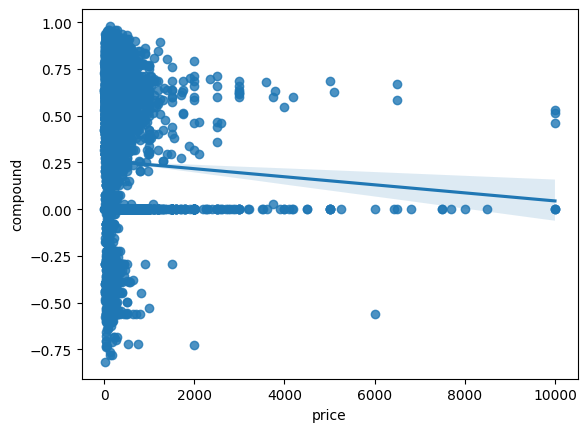

In [33]:
import seaborn as sns
sns.regplot(x = abb.price, y = abb.compound)